In [62]:
# International Standard Content Code (ISCC)
# Image Content Code Example
# Developed by ISCC Foundation - Titusz Pan
import matplotlib.pyplot as plt
import math
import numpy as np
from PIL import Image
from typing import List, Sequence
from statistics import median
from typing import Sequence
from more_itertools import chunked

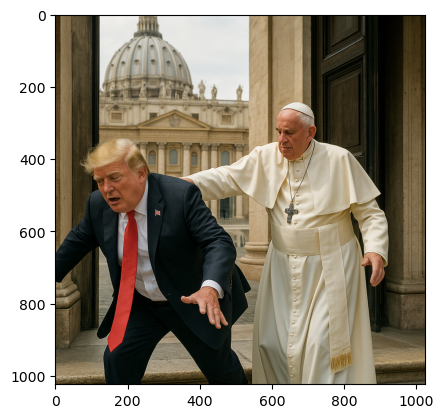

In [63]:
# Load oiginal image
original_img = Image.open("./images/Papst vertreibt Trump aus dem Vatikan.png")
plt.imshow(original_img, cmap="grey")

In [64]:
# Replace background color from transparent to white
white_bg = Image.new("RGBA", original_img.size, (255, 255, 255, 255))
original_img = Image.alpha_composite(white_bg, original_img.convert("RGBA"))

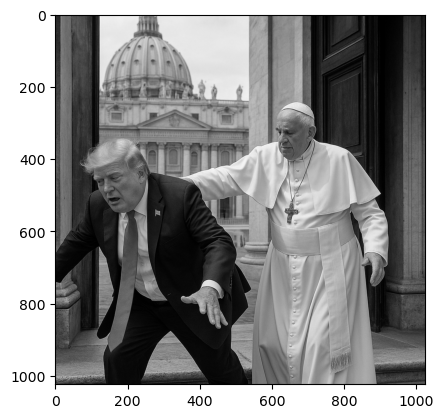

In [65]:
# Convert image to greyscale
greyscaled_img = original_img.convert('L')
plt.imshow(greyscaled_img, cmap="grey")

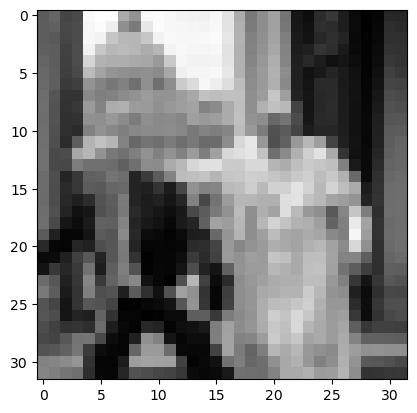

In [66]:
# Resize the greyscale image to 32x32 pixels
greyscaled_img_32x32 = greyscaled_img.resize((32,32),Image.BICUBIC)
plt.imshow(greyscaled_img_32x32, cmap="grey")

In [67]:
# Function for discrete cosine transform that ISCC is using
def alg_dct(v):
    # type: (Sequence[float]) -> List
    """
    Discrete cosine transform.
    See: [nayuki.io](https://www.nayuki.io/page/fast-discrete-cosine-transform-algorithms).
    :param Sequence[float] v: Input vector for DCT calculation.
    :return: DCT Transformed vector.
    :rtype: List
    """
    n = len(v)
    if n == 1:
        return list(v)
    elif n == 0 or n % 2 != 0:
        raise ValueError()
    else:
        half = n // 2
        alpha = [(v[i] + v[-(i + 1)]) for i in range(half)]
        beta = [
            (v[i] - v[-(i + 1)]) / (math.cos((i + 0.5) * math.pi / n) * 2.0) for i in range(half)
        ]
        alpha = alg_dct(alpha)
        beta = alg_dct(beta)
        result = []
        for i in range(half - 1):
            result.append(alpha[i])
            result.append(beta[i] + beta[i + 1])
        result.append(alpha[-1])
        result.append(beta[-1])
        return result

In [68]:
# ISCC uses fix image bit size (default 64)
image_bits = 64

In [69]:
# Load pixels of greyscaled resized image
pixels: list[int] = list(greyscaled_img_32x32.getdata())

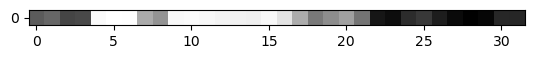

In [70]:
plt.yticks([0])
plt.ylim(-0.5, 0.5)
plt.imshow(np.array(greyscaled_img_32x32)[:32], cmap="grey")

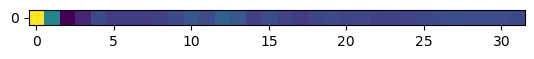

In [71]:
dct_row_lists_test = []
dct_row_lists_test.append(alg_dct(pixels[:32]))
plt.yticks([0])
plt.ylim(-0.5, 0.5)
plt.imshow(dct_row_lists_test, cmap="viridis") # viridis

In [72]:
dct_row_lists_test[0]

[4054,
 1225.2899372923403,
 -1129.9279188172368,
 -596.4178529017424,
 38.13239540895643,
 -218.12104692665397,
 -205.95375462722058,
 -216.9143966557399,
 -111.42267132722378,
 17.584269803842417,
 228.0605787582537,
 68.19316742657693,
 486.6686273123299,
 283.84296573108634,
 -126.48997475420315,
 50.43423917122519,
 -77.78174593052022,
 -216.4420815729763,
 -50.75273699149092,
 5.821165338593275,
 -57.31776187856265,
 -31.550763207297905,
 -123.69393177820443,
 -105.28687170888225,
 -91.61325403185641,
 -4.219451761035089,
 41.79375978527616,
 117.869217403712,
 80.95827186606583,
 72.95107696711915,
 46.86000968376044,
 -11.70721774653602]

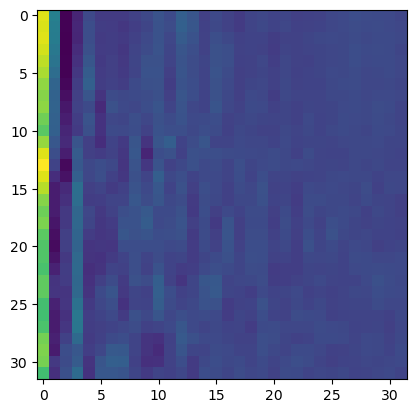

In [73]:
# DCT per row
dct_row_lists = []
for pixel_list in chunked(pixels, 32):
    dct_row_lists.append(alg_dct(pixel_list))
plt.imshow(dct_row_lists, cmap="viridis")

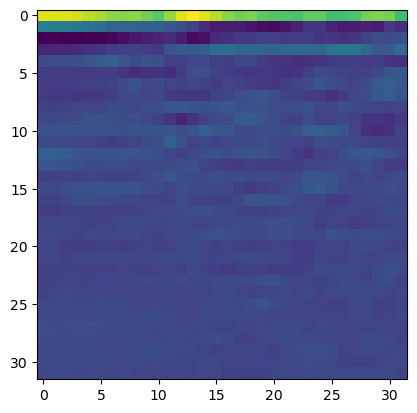

In [74]:
# Transpose matrix
dct_row_lists_t = list(map(list, zip(*dct_row_lists)))
plt.imshow(dct_row_lists_t, cmap="viridis")

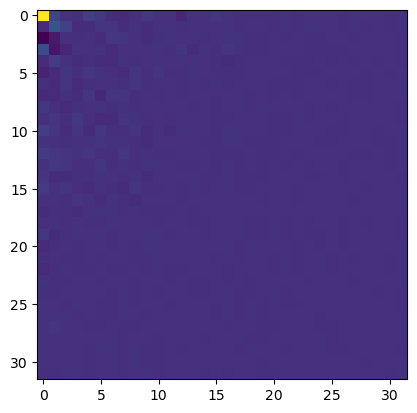

In [75]:
# DCT per column
dct_col_lists_t = []
for dct_list in dct_row_lists_t:
    dct_col_lists_t.append(alg_dct(dct_list))
plt.imshow(dct_col_lists_t, cmap="viridis")

In [76]:
# Transpose matrix back
dct_matrix = list(map(list, zip(*dct_col_lists_t)))

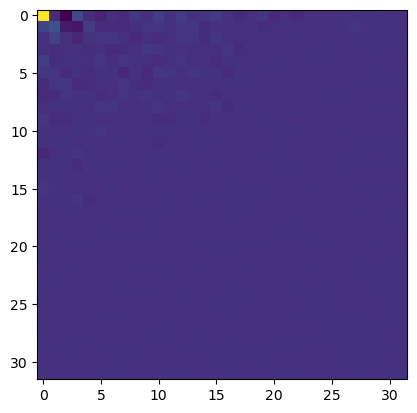

In [77]:
plt.imshow(dct_matrix, cmap="viridis")

In [78]:
# Function to extract 8x8 slices
def flatten(m, x, y):
    """Extract and flatten an 8 x 8 slice from a 2d matrix starting at col/row."""
    return [v for sublist in m[y : y + 8] for v in sublist[x : x + 8]]

In [79]:
# Variable to hold bitstring result of ISCC
bitstring = ""
# Position of 8x8 slices: upper left, upper right, bottom left, bottom right
slices = ((0, 0), (1, 0), (0, 1), (1, 1))

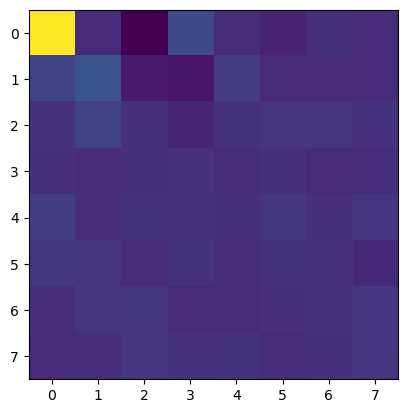

In [80]:
# For each slice
for xy in slices:
    # Extract 8 x 8 slice
    flat_list = flatten(dct_matrix, *xy)
    plt.imshow([flat_list[i : i + 8] for i in range(0, len(flat_list), 8)], cmap="viridis")
    # Calculate median
    med = median(flat_list)  
    # Append 64-bit digest by comparing to median
    for value in flat_list:
        if value > med:
            bitstring += "1"
        else:
            bitstring += "0"
    bl = len(bitstring)
    if bl >= image_bits:
        hash_digest = int(bitstring, 2).to_bytes(bl // 8, "big", signed=False)
        break

iscc content code: 1001000011001000110011110011000010110101110101100110001100111011


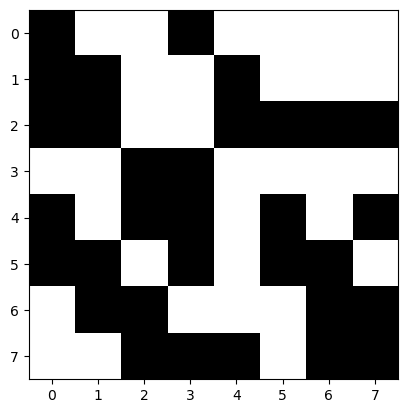

In [81]:
print(f"iscc content code: {bitstring}")
# Convert bitstirng to bitarray
bitarray = np.array([int(bit) for bit in bitstring])
# Map 1→255, 0→0
bitarray = bitarray * 255
# Reshape bitarray into 8x8
bitarray = bitarray.reshape(8, 8)
# Plot bitarray
plt.imshow(bitarray, cmap="Greys")